# Week 3 - Attitude Control of States and Rates

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, r"../")
import AttitudeKinematicsLib as ak

In [2]:
print("Contents of AttitudeKinematicsLib:")
for name in sorted(dir(ak)):
    if not name.startswith("_"):
        print(name)

Contents of AttitudeKinematicsLib:
BInvmat_CRP
BInvmat_EP
BInvmat_Euler
BInvmat_MRP
BInvmat_PRV
Bmat_CRP
Bmat_EP
Bmat_Euler
Bmat_MRP
Bmat_PRV
CRP
CRP_to_DCM
DCM_to_CRP
DCM_to_EP
DCM_to_Euler
DCM_to_MRP
DCM_to_PRV
DCM_utils
EP_to_DCM
EulerAngles
EulerRodriguesParameters
Euler_to_DCM
MRP
MRP_to_DCM
PRV
PRV_to_DCM
integrate_quaternion
normalize_quat
np
quat_derivative
quat_diff
quat_inv
quat_mult
rotation_matrix_x
rotation_matrix_y
rotation_matrix_z
skew_symmetric
solve_ivp
validate_DCM
validate_vec3
validate_vec4


## CC1, Q4

In [3]:
def mrp_shadow(sigma: np.ndarray) -> np.ndarray:
    """
    Apply MRP shadow set if ||sigma|| > 1.
    Keeps MRPs numerically well-conditioned.
    """
    s2 = float(sigma @ sigma)
    if s2 > 1.0:
        return -sigma / s2
    return sigma

In [4]:
def q4_rhs(t: float, x: np.ndarray, I: np.ndarray, K: float, P: float) -> np.ndarray:
    """
    Compute the continuous-time state derivative for the Q4 attitude regulator.
    
    Parameters
    ----------
    t : float
        Time variable (not used explicitly; included for ODE compatibility).
    x : np.ndarray
        State vector [sigma_BN (3,), omega_BN (3,)], where omega_BN is expressed
        in the body frame.
    I : np.ndarray
        3×3 spacecraft inertia matrix expressed in the body frame.
    K : float
        Proportional attitude gain.
    P : float
        Rate damping gain.
    
    Returns
    -------
    xdot : np.ndarray
        State derivative [sigma_dot_BN (3,), omega_dot_BN (3,)].
    """
    # --- unpack state ---
    sigma = mrp_shadow(x[0:3])
    omega = x[3:6]

    # --- control law (regulator, R = N) ---
    # u = -K*sigma - P*omega + omega x (I*omega)
    u = (-K * sigma - P * omega + np.cross(omega, I @ omega))

    # --- rigid-body dynamics ---
    # I * omega_dot = u - omega x (I*omega)
    omega_dot = np.linalg.solve(I, u - np.cross(omega, I @ omega))

    # --- MRP kinematics ---
    # sigma_dot = 1/4 * B(sigma) * omega
    B = ak.Bmat_MRP(sigma)
    sigma_dot = 0.25 * (B @ omega)

    xdot = np.hstack((sigma_dot, omega_dot))

    return xdot


In [5]:
def rk4_step(f, t, x, dt, *args, **kwargs):
    """
    Advance one timestep using classical 4th-order Runge–Kutta (RK4).
    
    Parameters
    ----------
    f : callable
        RHS function with signature f(t, x, *args, **kwargs) -> xdot.
    t : float
        Current time.
    x : np.ndarray
        Current state vector.
    dt : float
        Timestep size.
    *args, **kwargs
        Extra arguments passed through to `f`.
    
    Returns
    -------
    x_next : np.ndarray
        State advanced by one RK4 step of size `dt`.
    """
    k1 = f(t, x, *args, **kwargs)
    k2 = f(t + 0.5*dt, x + 0.5*dt*k1, *args, **kwargs)
    k3 = f(t + 0.5*dt, x + 0.5*dt*k2, *args, **kwargs)
    k4 = f(t + dt, x + dt*k3, *args, **kwargs)
    x_next = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return x_next


In [6]:
def simulate_q4():
    # --- spacecraft parameters ---
    I = np.diag([100.0, 75.0, 80.0])   # kg*m^2
    K = 5.0                            # N*m
    P = 10.0                           # N*m*s

    # --- initial conditions ---
    sigma0 = np.array([0.1, 0.2, -0.1])
    omega0 = np.deg2rad([30.0, 10.0, -20.0])  # rad/s
    x0 = np.hstack((sigma0, omega0))

    # --- time settings ---
    t0, tf = 0.0, 120.0
    dt = 0.01

    N = int((tf - t0) / dt) + 1
    t_hist = np.linspace(t0, tf, N)

    x_hist = np.zeros((N, 6))
    u_hist = np.zeros((N, 3))
    V_hist = np.zeros(N)

    x_hist[0] = x0

    # --- integrate ---
    for k in range(N - 1):
        t = t_hist[k]
        x = x_hist[k]

        # compute control (for logging)
        sigma = mrp_shadow(x[0:3])
        omega = x[3:6]
        u = -K * sigma - P * omega + np.cross(omega, I @ omega)

        u_hist[k] = u
        V_hist[k] = 0.5 * omega @ (I @ omega) + 0.5 * K * (sigma @ sigma)

        # RK4 step
        x_next = rk4_step(q4_rhs, t, x, dt, I, K, P)
        x_next[0:3] = mrp_shadow(x_next[0:3])
        x_hist[k + 1] = x_next

    # last energy value
    sigma = x_hist[-1, 0:3]
    omega = x_hist[-1, 3:6]
    V_hist[-1] = 0.5 * omega @ (I @ omega) + 0.5 * K * (sigma @ sigma)

    # quiz output
    idx_30 = int(30.0 / dt)
    print(f"Q4: ||sigma_BN|| at t=30 s = {np.linalg.norm(x_hist[idx_30,0:3]):.15f}")

    results = {
        "t": t_hist,
        "x": x_hist,
        "u": u_hist,
        "V": V_hist,
        "params": {"I": I, "K": K, "P": P}
    }
    return results 


q4_sim_result = simulate_q4()
q4_sim_result

Q4: ||sigma_BN|| at t=30 s = 0.194750611871007


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01029530e-01,  2.00444264e-01, -1.01317420e-01,
          5.23025206e-01,  1.74166977e-01, -3.48566918e-01],
        [ 1.02058633e-01,  2.00886941e-01, -1.02634236e-01,
          5.22451696e-01,  1.73801221e-01, -3.48067787e-01],
        ...,
        [-1.01918013e-03,  3.56154752e-05,  5.41532586e-04,
         -3.76229175e-04,  4.65625211e-05, -8.66542380e-05],
        [-1.02011974e-03,  3.57303144e-05,  5.41315494e-04,
         -3.75343563e-04,  4.64767130e-05, -8.68841665e-05],
        [-1.02105713e-03,  3.58449405e-05,  5.41097828e-04,
         -3.74458368e-04,  4.63909428e-05, -8.71136720e-05]]),
 'u': array([[-6.04060518e+00, -6.40073829e+00,  1.70602786e+00],
        [-6.03894394e+00, -6.39007678e+00,  1.71491330e+00],
        [-6.03728315e+00, -

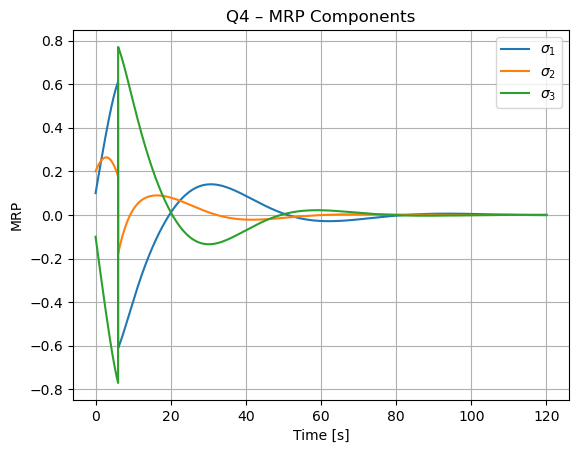

In [7]:
t = q4_sim_result['t']
x = q4_sim_result['x']
u = q4_sim_result['u']
V = q4_sim_result['V']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q4 – MRP Components")
plt.legend()
plt.show()

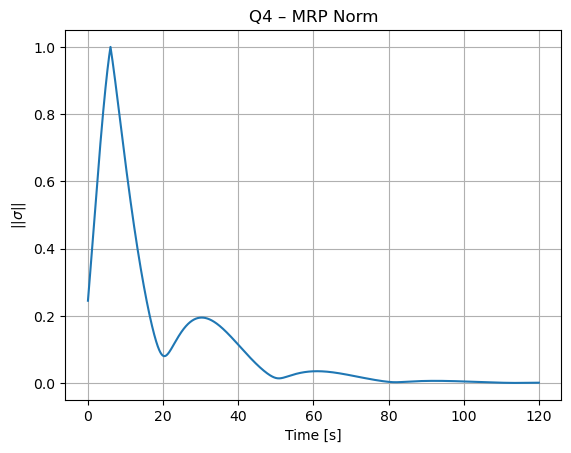

In [8]:
plt.figure()
plt.plot(t, np.linalg.norm(sigma, axis=1))
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$||\sigma||$")
plt.title("Q4 – MRP Norm")
plt.show()


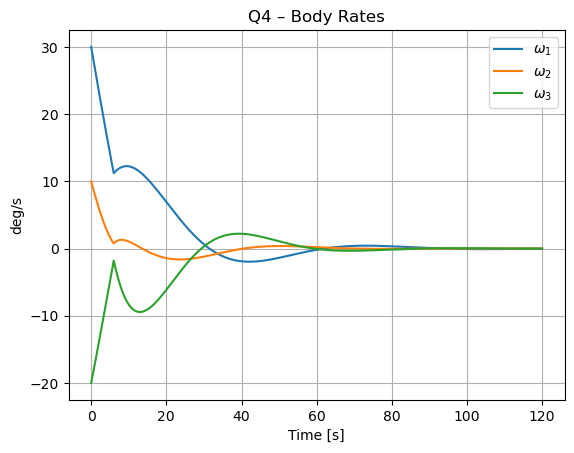

In [9]:
plt.figure()
plt.plot(t, omega_deg[:, 0], label=r'$\omega_1$')
plt.plot(t, omega_deg[:, 1], label=r'$\omega_2$')
plt.plot(t, omega_deg[:, 2], label=r'$\omega_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q4 – Body Rates")
plt.legend()
plt.show()

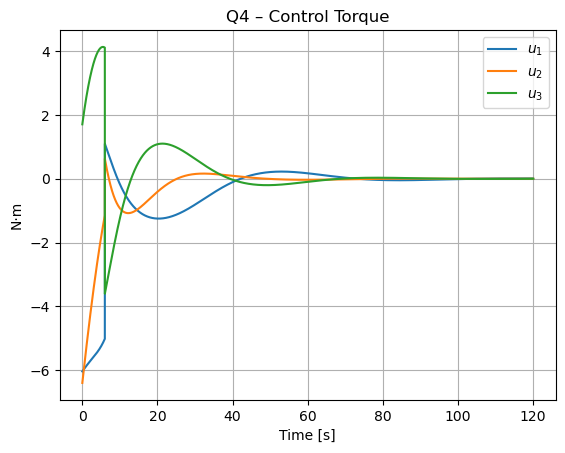

In [10]:
plt.figure()
plt.plot(t, u[:, 0], label=r'$u_1$')
plt.plot(t, u[:, 1], label=r'$u_2$')
plt.plot(t, u[:, 2], label=r'$u_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("N·m")
plt.title("Q4 – Control Torque")
plt.legend()
plt.show()


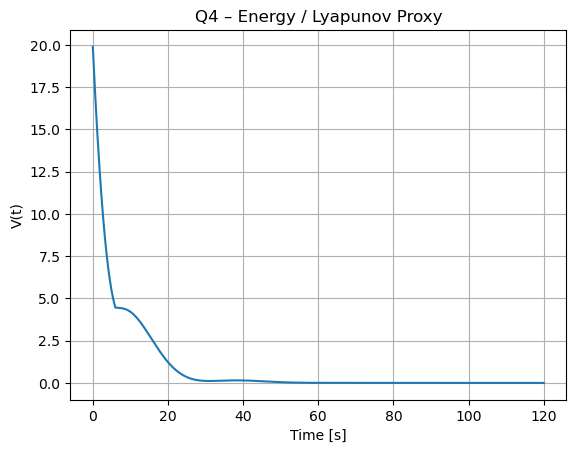

In [11]:
plt.figure()
plt.plot(t, V)
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("V(t)")
plt.title("Q4 – Energy / Lyapunov Proxy")
plt.show()


## CC1, Q5

In [12]:
# ---- Reference (Q5) ----
def sigma_RN(t: float, f: float = 0.05) -> np.ndarray:
    """
    Reference attitude MRPs sigma_{R/N}(t).

    Parameters
    ----------
    t : float
        Time [s].
    f : float
        Reference frequency [rad/s].

    Returns
    -------
    sigma : np.ndarray
        MRPs (3,) representing attitude of R relative to N.
    """
    sigma = np.array([
        0.2 * np.sin(f * t),
        0.3 * np.cos(f * t),
       -0.3 * np.sin(f * t)
    ], dtype=float)
    return sigma


def sigma_RN_dot(t: float, f: float = 0.05) -> np.ndarray:
    """
    Time-derivative of reference MRPs d/dt sigma_{R/N}(t).

    Parameters
    ----------
    t : float
        Time [s].
    f : float
        Reference frequency [rad/s].

    Returns
    -------
    sigma_dot : np.ndarray
        Time-derivative of MRPs (3,).
    """
    sigma_dot = np.array([
        0.2 * f * np.cos(f * t),
       -0.3 * f * np.sin(f * t),
       -0.3 * f * np.cos(f * t)
    ], dtype=float)
    return sigma_dot


def omega_RN_R_from_mrp(t: float, f: float = 0.05) -> np.ndarray:
    """
    Compute reference angular rate omega_{R/N} expressed in R from MRP kinematics.

    Uses:
        sigma_dot = 1/4 * B(sigma) * omega   =>   omega = 4 * B^{-1}(sigma) * sigma_dot

    Parameters
    ----------
    t : float
        Time [s].
    f : float
        Reference frequency [rad/s].

    Returns
    -------
    omega_RN_R : np.ndarray
        Angular rate omega_{R/N} expressed in frame R (3,) [rad/s].
    """
    sigma = mrp_shadow(sigma_RN(t, f))
    sigma_dot = sigma_RN_dot(t, f)

    Binv = ak.BInvmat_MRP(sigma)
    omega_RN_R = 4.0 * (Binv @ sigma_dot)
    return omega_RN_R


def omega_RN_R_dot_fd(t: float, f: float = 0.05, h: float = 1e-6) -> np.ndarray:
    """
    Numerical time derivative of omega_{R/N}^R via central difference.

    Parameters
    ----------
    t : float
        Time [s].
    f : float
        Reference frequency [rad/s].
    h : float
        Finite-difference step [s].

    Returns
    -------
    omega_RN_R_dot : np.ndarray
        Time derivative of omega_{R/N} expressed in R (3,) [rad/s^2].
    """
    w_minus = omega_RN_R_from_mrp(t - h, f)
    w_plus  = omega_RN_R_from_mrp(t + h, f)

    omega_RN_R_dot = (w_plus - w_minus) / (2.0 * h)
    return omega_RN_R_dot


In [13]:
def q5_rhs(t: float,
           x: np.ndarray,
           I: np.ndarray,
           K: float,
           P: float,
           f: float = 0.05) -> np.ndarray:
    """
    Continuous-time state derivative for Q5 tracking case.

    State:
        x = [sigma_BN (3,), omega_BN (3,)]
    where omega_BN is expressed in the body frame B.
    """

    # --- unpack state ---
    sigma_BN = mrp_shadow(x[0:3])
    omega_BN_B = x[3:6]

    # --- reference attitude and rates ---
    sigma_RN_ref = mrp_shadow(sigma_RN(t, f))
    omega_RN_R = omega_RN_R_from_mrp(t, f)
    omega_RN_R_dot = omega_RN_R_dot_fd(t, f)

    # --- DCMs ---
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN_ref)

    # Attitude error via DCMs
    C_BR = C_BN @ C_RN.T
    sigma_BR = mrp_shadow(ak.DCM_to_MRP(C_BR))

    # --- rate error in B ---
    omega_RN_B = C_BR @ omega_RN_R
    omega_RN_B_dot = C_BR @ omega_RN_R_dot
    omega_BR_B = omega_BN_B - omega_RN_B

    # --- control law (tracking) ---
    u = (-K * sigma_BR - P * omega_BR_B + I @ (omega_RN_B_dot - np.cross(omega_BN_B, omega_RN_B)) + np.cross(omega_BN_B, I @ omega_BN_B))

    # --- rigid body dynamics ---
    omega_dot = np.linalg.solve(I, (u - np.cross(omega_BN_B, I @ omega_BN_B)))

    # --- kinematics ---
    sigma_dot = 0.25 * (ak.Bmat_MRP(sigma_BN) @ omega_BN_B)

    # --- assemble state derivative ---
    xdot = np.hstack((sigma_dot, omega_dot))
    return xdot


In [14]:
def simulate_q5():
    # --- spacecraft parameters ---
    I = np.diag([100.0, 75.0, 80.0])   # kg*m^2
    K = 5.0                            # N*m
    P = 10.0                           # N*m*s
    f = 0.05                           # rad/s

    # --- initial conditions ---
    sigma0 = np.array([0.1, 0.2, -0.1], dtype=float)
    omega0 = np.deg2rad([30.0, 10.0, -20.0]).astype(float)
    x0 = np.hstack((sigma0, omega0))

    # --- time settings ---
    t0, tf = 0.0, 120.0
    dt = 0.01

    N = int((tf - t0) / dt) + 1
    t_hist = np.linspace(t0, tf, N)

    x_hist = np.zeros((N, 6), dtype=float)
    x_hist[0] = x0

    # logs
    sigma_BR_hist = np.zeros((N, 3), dtype=float)
    omega_BR_hist = np.zeros((N, 3), dtype=float)

    # --- integrate ---
    for k in range(N - 1):
        t = t_hist[k]
        x = x_hist[k]

        # ----- compute tracking errors for logging -----
        sigma_BN = mrp_shadow(x[0:3])
        omega_BN_B = x[3:6]

        C_BN = ak.MRP_to_DCM(sigma_BN)

        sigma_RN_ref = mrp_shadow(sigma_RN(t, f))
        C_RN = ak.MRP_to_DCM(sigma_RN_ref)

        C_BR = C_BN @ C_RN.T
        sigma_BR = mrp_shadow(ak.DCM_to_MRP(C_BR))

        omega_RN_R = omega_RN_R_from_mrp(t, f)
        omega_RN_B = C_BR @ omega_RN_R
        omega_BR_B = omega_BN_B - omega_RN_B

        sigma_BR_hist[k] = sigma_BR
        omega_BR_hist[k] = omega_BR_B

        # ----- RK4 step -----
        x_next = rk4_step(q5_rhs, t, x, dt, I, K, P, f)
        x_next[0:3] = mrp_shadow(x_next[0:3])

        x_hist[k + 1] = x_next

    # copy last logged value (so arrays align with t_hist)
    sigma_BR_hist[-1] = sigma_BR_hist[-2]
    omega_BR_hist[-1] = omega_BR_hist[-2]

    # ---- quiz value: ||sigma_{B/R}|| at t = 40 s ----
    idx_40 = int(round(40.0 / dt))
    q5_value = float(np.linalg.norm(sigma_BR_hist[idx_40]))
    print(f"Q5: ||sigma_B/R|| at t=40 s = {q5_value:.15f}")

    results = {
        "t": t_hist,
        "x": x_hist,
        "sigma_BR": sigma_BR_hist,
        "omega_BR": omega_BR_hist,
        "params": {"I": I, "K": K, "P": P, "f": f, "dt": dt}
    }
    return results


q5_sim_result = simulate_q5()
q5_sim_result

Q5: ||sigma_B/R|| at t=40 s = 0.158755064578136


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102978,  0.20044435, -0.1013174 ,  0.523179  ,  0.17427502,
         -0.34850356],
        [ 0.10205962,  0.20088729, -0.10263417,  0.52275889,  0.17401823,
         -0.34794101],
        ...,
        [-0.05648062,  0.2880557 ,  0.0841535 ,  0.06062994,  0.01183206,
         -0.02395723],
        [-0.05638208,  0.28809831,  0.08400767,  0.06063406,  0.0118117 ,
         -0.02396355],
        [-0.05628353,  0.28814084,  0.08386181,  0.06063818,  0.01179134,
         -0.02396986]]),
 'sigma_BR': array([[ 0.13417452, -0.0888573 , -0.02754576],
        [ 0.13552741, -0.08828624, -0.02796309],
        [ 0.13687888, -0.0877151 , -0.0283799 ],
        ...,
        [-0.00031979,  0.00014542, -0.00014883],
        [-0.0003169 ,  0.00014551, -0.00014903],
        [-0.0003169 ,  0.000

In [15]:
t = q5_sim_result["t"]
x = q5_sim_result["x"]
sigma_BR = q5_sim_result["sigma_BR"]
omega_BR = q5_sim_result["omega_BR"]

sigma_BN = x[:, 0:3]
omega_BN = x[:, 3:6]
omega_BN_deg = np.rad2deg(omega_BN)

omega_BR_deg = np.rad2deg(omega_BR)

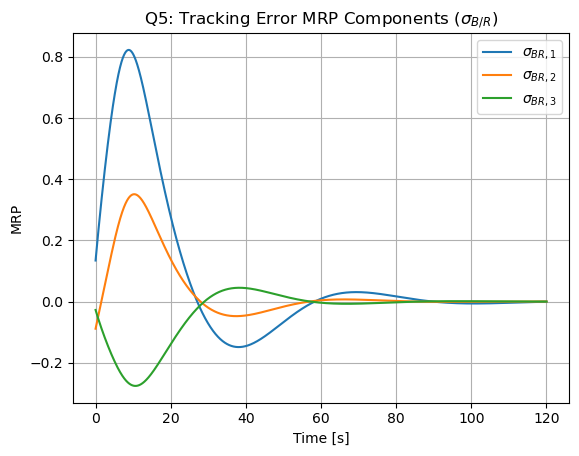

In [16]:
plt.figure()
plt.plot(t, sigma_BR[:, 0], label=r'$\sigma_{BR,1}$')
plt.plot(t, sigma_BR[:, 1], label=r'$\sigma_{BR,2}$')
plt.plot(t, sigma_BR[:, 2], label=r'$\sigma_{BR,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q5: Tracking Error MRP Components ($\\sigma_{B/R}$)")
plt.legend()
plt.show()


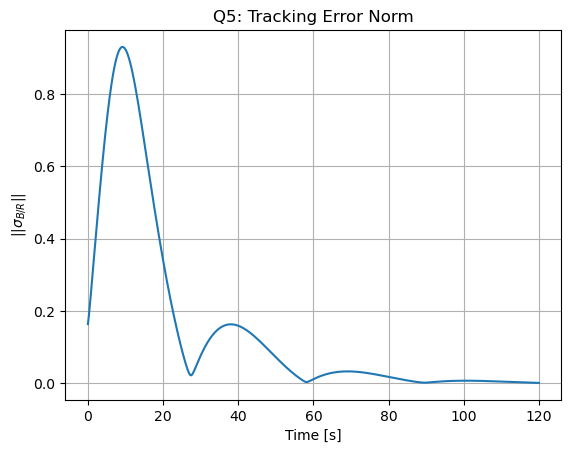

In [17]:
plt.figure()
plt.plot(t, np.linalg.norm(sigma_BR, axis=1))
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$||\sigma_{B/R}||$")
plt.title("Q5: Tracking Error Norm")
plt.show()


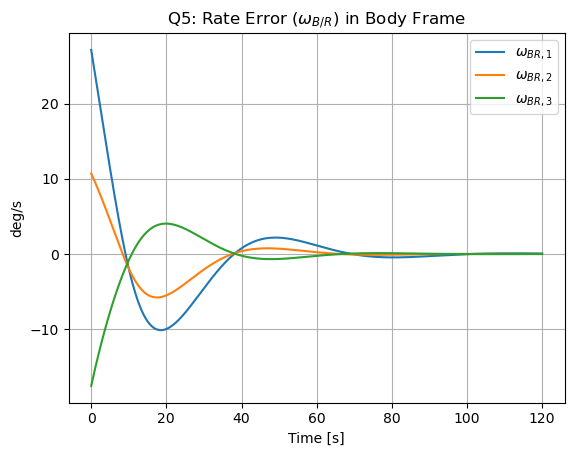

In [18]:
plt.figure()
plt.plot(t, omega_BR_deg[:, 0], label=r'$\omega_{BR,1}$')
plt.plot(t, omega_BR_deg[:, 1], label=r'$\omega_{BR,2}$')
plt.plot(t, omega_BR_deg[:, 2], label=r'$\omega_{BR,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q5: Rate Error ($\\omega_{B/R}$) in Body Frame")
plt.legend()
plt.show()


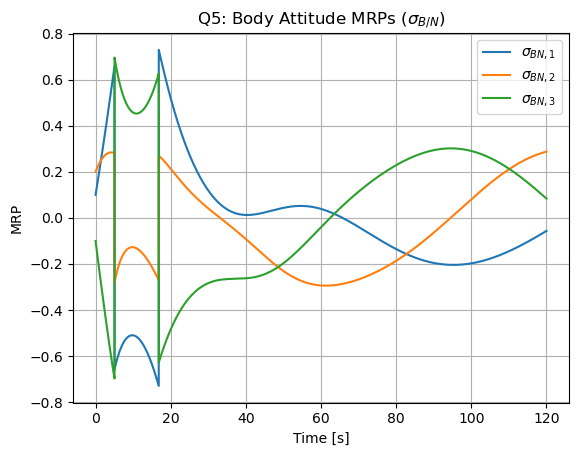

In [19]:
plt.figure()
plt.plot(t, sigma_BN[:, 0], label=r'$\sigma_{BN,1}$')
plt.plot(t, sigma_BN[:, 1], label=r'$\sigma_{BN,2}$')
plt.plot(t, sigma_BN[:, 2], label=r'$\sigma_{BN,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q5: Body Attitude MRPs ($\\sigma_{B/N}$)")
plt.legend()
plt.show()


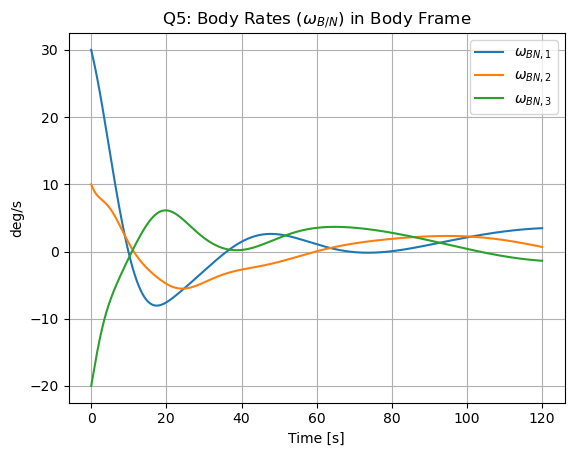

In [20]:
plt.figure()
plt.plot(t, omega_BN_deg[:, 0], label=r'$\omega_{BN,1}$')
plt.plot(t, omega_BN_deg[:, 1], label=r'$\omega_{BN,2}$')
plt.plot(t, omega_BN_deg[:, 2], label=r'$\omega_{BN,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q5: Body Rates ($\\omega_{B/N}$) in Body Frame")
plt.legend()
plt.show()


In [22]:
dt = q5_sim_result["params"]["dt"]
idx_40 = int(round(40.0 / dt))
sig40 = float(np.linalg.norm(sigma_BR[idx_40]))
print(f"||sigma_B/R|| at t=40 s = {sig40:.15f}")

||sigma_B/R|| at t=40 s = 0.158755064578136
